<a href="https://colab.research.google.com/github/dantebarross/scientific-projects-with-python/blob/main/State_space_trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# State-space trajectories via PCA

PCA = Principal Component Analysis

When there is a correlation between variable A and B, PCA try to identify the axis of maximal similarity (PC1) or variability (PC2) between these two variables.

- It allows us to redraw the data in Principal Components Space.
- And then we can compress data into a 1D (one dimensional) space.
- So we can start with many dimensions and compress down to two dimensions (PC1 and PC2), and compress into one dimension.

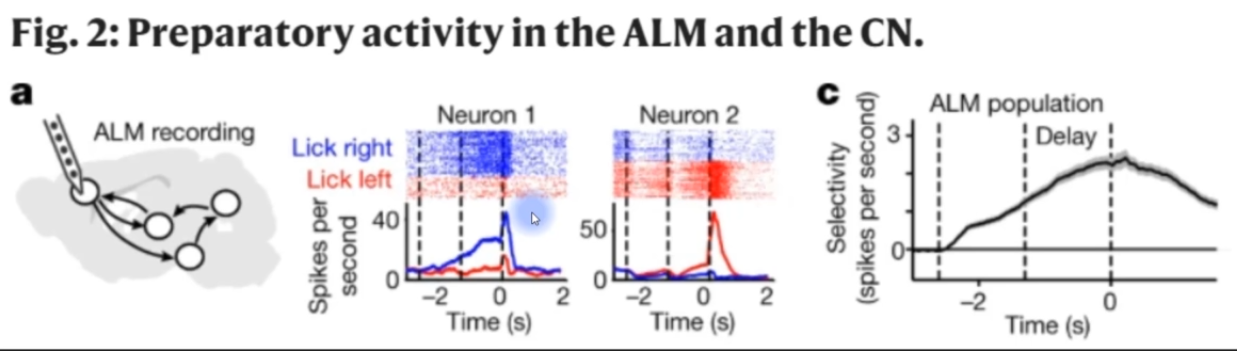

The dataset: data from 64 different neurons (64 dimensions), and we're going to do a PCA and see whether there are some interesting trajectories/dynamics that are occurring in a lower dimensional feature space that we can extract by looking at the correlational structure across 64 neurons.

# Importing, inspecting and cleaning data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.io import loadmat # to import a matlab file in python environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
matdat = loadmat('/content/gdrive/MyDrive/Colab Notebooks/ALMdata.mat')
matdat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jul 21 07:38:12 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Channel_all': array([[ 1],
        [11],
        [14],
        ...,
        [13],
        [13],
        [14]], dtype=uint8),
 'PSTH_nonprefer_cue_aligned': array([[ 0.11764706,  0.11764706,  0.11764706, ...,  3.76470588,
          3.64705882,  3.76470588],
        [ 0.0862069 ,  0.0862069 ,  0.0862069 , ...,  0.0862069 ,
          0.0862069 ,  0.0862069 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.4       ,
          0.4       ,  0.4       ],
        ...,
        [ 1.53846154,  1.53846154,  1.53846154, ...,  2.15384615,
          2.15384615,  2.15384615],
        [11.16438356, 11.30136986, 11.36986301, ..., 18.42465753,
         18.42465753, 18.49315068],
        [ 3.45238095,  3.51190476,  3.51190476, ...,  2.38095238,
          2.5       ,  2.55952381]]),
 'PSTH_prefer_cue_aligned': array([[ 0.        ,  0.        ,  0.        , ..

In [ ]:
Nopr = matdat['PSTH_nonprefer_cue_aligned'] # non-prefered
Pref = matdat['PSTH_prefer_cue_aligned'] # prefered
t = matdat['t'][0] # time vector
chanidx = matdat['Channel_all'] # which rows in data matrix correspond to which channel of which neuron

In [ ]:
print(Nopr.shape)
print(Pref.shape)
print(t.shape)
print(chanidx.shape)

chanidx = chanidx.flatten()

(1186, 5101)
(1186, 5101)
(5101,)
(1186, 1)


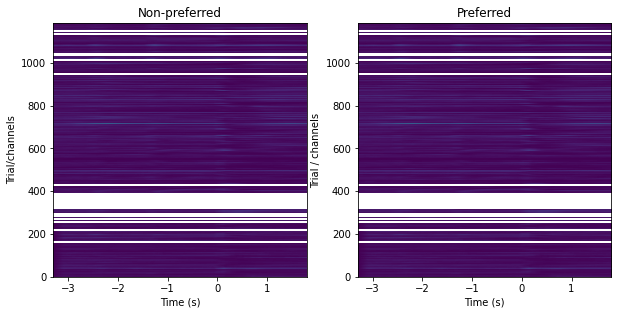

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(Nopr, extent=[t[0], t[-1], 0, Nopr.shape[0]], origin='top')
ax[0].set_aspect(1/ax[0].get_data_ratio())
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Trial/channels')
ax[0].set_title('Non-preferred')

ax[1].imshow(Nopr, extent=[t[0], t[-1], 0, Pref.shape[0]], origin='top')
ax[1].set_aspect(1/ax[1].get_data_ratio())
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Trial / channels')
ax[1].set_title('Preferred')
plt.show()

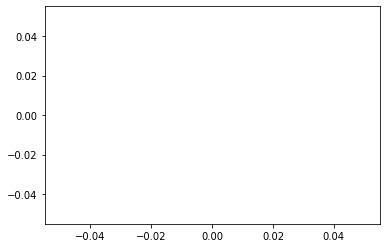

array([nan, nan, nan, ..., nan, nan, nan])

In [ ]:
plt.plot(t, Nopr[380, :]) # let's show row 380 only
plt.show()
Nopr[380, :] # NaN

In [ ]:
np.isfinite(5)

True

In [ ]:
np.isfinite(np.nan)

False

In [ ]:
# let's get rid of NaN values

Nopr = Nopr[np.isfinite(Nopr[:,0]), :]
Nopr.shape
chanidx = chanidx[np.isfinite(Pref[:,0])]
Pref = Pref[np.isfinite(Pref[:,0]), :]


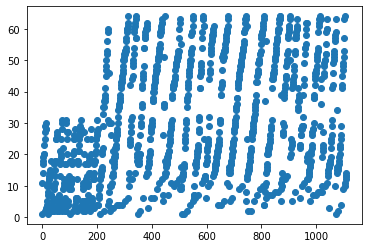

In [ ]:
plt.plot(chanidx, 'o')
plt.show()

In [ ]:
np.unique(chanidx)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], dtype=uint8)

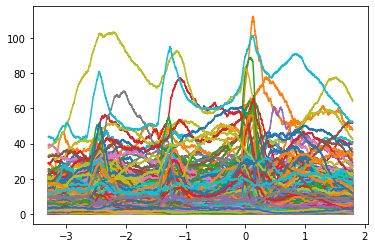

In [ ]:
plt.plot(t, Nopr.T)
plt.show()

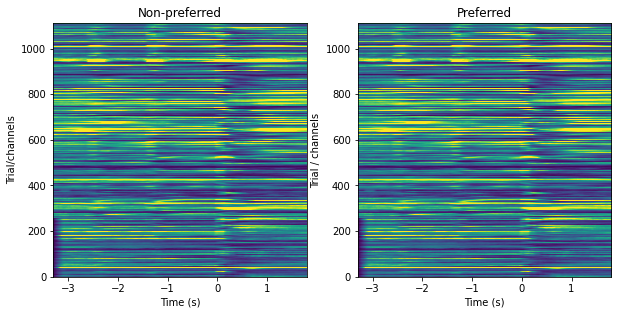

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(Nopr, extent=[t[0], t[-1], 0, Nopr.shape[0]], 
             origin='top', vmin=0, vmax=10)
ax[0].set_aspect(1/ax[0].get_data_ratio())
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Trial/channels')
ax[0].set_title('Non-preferred')

ax[1].imshow(Nopr, extent=[t[0], t[-1], 0, Pref.shape[0]], 
             origin='top', vmin=0, vmax=10)
ax[1].set_aspect(1/ax[1].get_data_ratio())
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Trial / channels')
ax[1].set_title('Preferred')
plt.show()

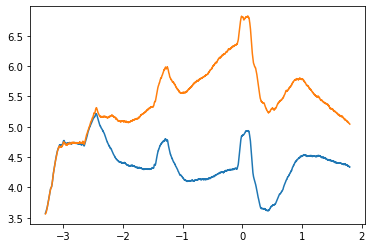

In [ ]:
plt.plot(t, np.mean(Nopr, axis=0), label='Nonpref')
plt.plot(t, np.mean(Pref , axis=0), label='Pref')
plt.show()

# Covariance matrix

Let's, create channel covariance matrix, and then do the PCA in the variance of the two  covariance matrix

In [ ]:
# computing new data matrices

nchans = np.max(chanidx)
chan_avg_Nopr = np.zeros((nchans, len(t)))
chan_avg_Pref = np.zeros((nchans, len(t)))

for i in range(1, nchans+1):
  chan_avg_Nopr[i-1, :] = np.mean(Nopr[chanidx==i, :], axis=0)
  chan_avg_Pref[i-1, :] = np.mean(Pref[chanidx==i, :], axis=0)

print(chan_avg_Nopr.shape)

(64, 5101)


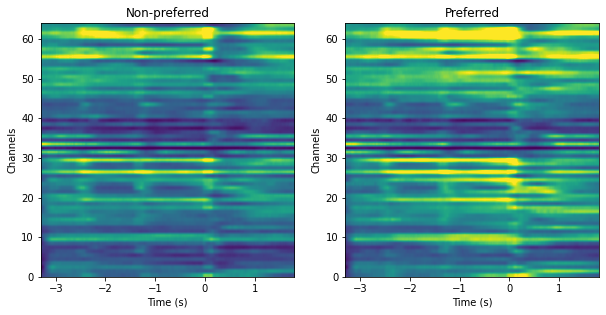

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(chan_avg_Nopr, extent=[t[0], t[-1], 0, nchans], 
             origin='top', vmin=0, vmax=10)
ax[0].set_aspect(1/ax[0].get_data_ratio())
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Channels')
ax[0].set_title('Non-preferred')

ax[1].imshow(chan_avg_Pref, extent=[t[0], t[-1], 0, nchans], 
             origin='top', vmin=0, vmax=10)
ax[1].set_aspect(1/ax[1].get_data_ratio())
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Channels')
ax[1].set_title('Preferred')
plt.show()

In [ ]:
# computing covariance matrices

cov_mat_Pref = np.cov(chan_avg_Pref)
cov_mat_Nopr= np.cov(chan_avg_Nopr)

cov_mat_Pref.shape

(64, 64)

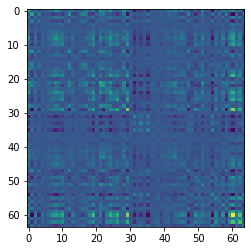

In [ ]:
plt.imshow(cov_mat_Pref)

Text(0, 0.5, 'Channels')

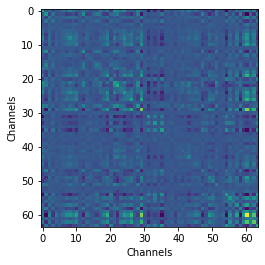

In [ ]:
cov_mat = (cov_mat_Nopr + cov_mat_Pref) / 2
plt.imshow(cov_mat)
plt.xlabel('Channels')
plt.ylabel('Channels')

# Eingen decomposition

A way to decompose a square matrix (same rows x columns) in values and vectors (eigenvalues and eigenvectors). Eigenvectors point important directions in the space of the matrix. Eigenvalues tell how much important is this vector.

PCA is nothing more than an eigen decomposition of a data covariance matrix.

In the end, we are going to have possibly interpretable values (measured by eigenvalue), and noise values (low variance components).

In [ ]:
eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)
eigenvalues

array([1.19220888e-03, 1.82960313e-03, 1.98752120e-03, 2.36221509e-03,
       2.72635790e-03, 2.94226372e-03, 3.23408311e-03, 3.74054198e-03,
       3.94066205e-03, 4.13811541e-03, 4.52469042e-03, 4.89325191e-03,
       5.36221410e-03, 6.47534970e-03, 6.91971262e-03, 7.04825032e-03,
       7.33634553e-03, 8.27233246e-03, 9.29968518e-03, 1.11163288e-02,
       1.18902083e-02, 1.22093433e-02, 1.43426081e-02, 1.56267205e-02,
       1.66123270e-02, 1.78417679e-02, 1.93809369e-02, 2.02527501e-02,
       2.31866693e-02, 2.65605059e-02, 2.79582355e-02, 3.13823891e-02,
       3.21707885e-02, 3.74090284e-02, 4.58473700e-02, 5.32540942e-02,
       6.05237164e-02, 6.43330572e-02, 7.23977894e-02, 8.28741240e-02,
       8.92402042e-02, 1.06937349e-01, 1.19640882e-01, 1.58930204e-01,
       1.87586524e-01, 2.10405554e-01, 2.77966112e-01, 2.95607963e-01,
       3.27276342e-01, 3.82553723e-01, 5.16801705e-01, 6.38730912e-01,
       7.29677831e-01, 9.22260661e-01, 1.02347617e+00, 1.14890922e+00,
      

In [ ]:
eigenvectors

array([[-0.03918911, -0.04664505, -0.0723436 , ..., -0.04900618,
         0.3119684 , -0.14097781],
       [ 0.05127987,  0.02231905,  0.05738581, ...,  0.16855678,
         0.18019278,  0.14828167],
       [ 0.02544526, -0.0618088 ,  0.02920079, ...,  0.07107654,
         0.0088369 , -0.11373988],
       ...,
       [ 0.01318936,  0.09570551,  0.01472337, ...,  0.19538214,
        -0.00505781, -0.07604354],
       [ 0.05867643, -0.02367819, -0.05965246, ...,  0.20764073,
         0.00544141, -0.27771874],
       [ 0.08428748,  0.00744164, -0.12604521, ...,  0.34357539,
        -0.08579707,  0.13568254]])

In [ ]:
print(eigenvalues.shape)
print(eigenvectors.shape)

(64,)
(64, 64)


In [ ]:
sorted_index = np.argsort(eigenvalues)[::-1] # ::-1 reversing the sort
print(sorted_index)

[63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40
 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16
 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]


In [ ]:
eigenvalues = eigenvalues[sorted_index]
eigenvectors = eigenvectors[:,sorted_index]

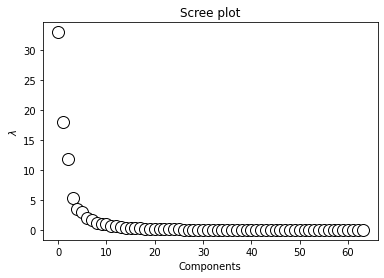

In [ ]:
plt.plot(eigenvalues, 'ko', markerfacecolor='w', markersize=12)
plt.xlabel('Components')
plt.ylabel('$\lambda$') # lambda to indicate the eigen value
plt.title('Scree plot') # in literature they call this Scree plot
plt.show()

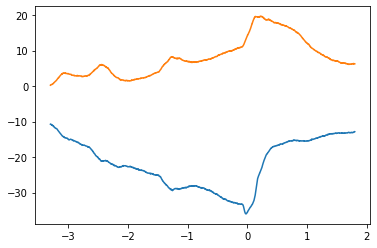

In [ ]:
# computing PC time series
pcNopr = eigenvectors[:, 0:2].T @ chan_avg_Nopr 
# the first two eigenvectors are the ones that we want cause we sorted the columns according to the eigenvalues
pcPref = eigenvectors[:,0:2].T @ chan_avg_Pref

plt.plot(t, pcPref.T)
plt.show()

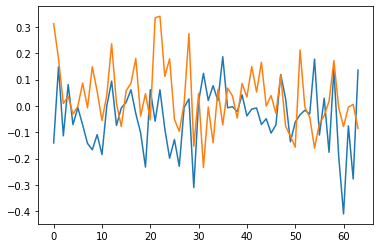

In [ ]:
plt.plot(eigenvectors[:, 0:2])

In [ ]:
for i in range(2):
  # find the largest component magnitude
  max_index = np.argmax(abs(eigenvectors[:,i]))
  eigenvectors[:, i] *= np.sign(eigenvectors[max_index, i])

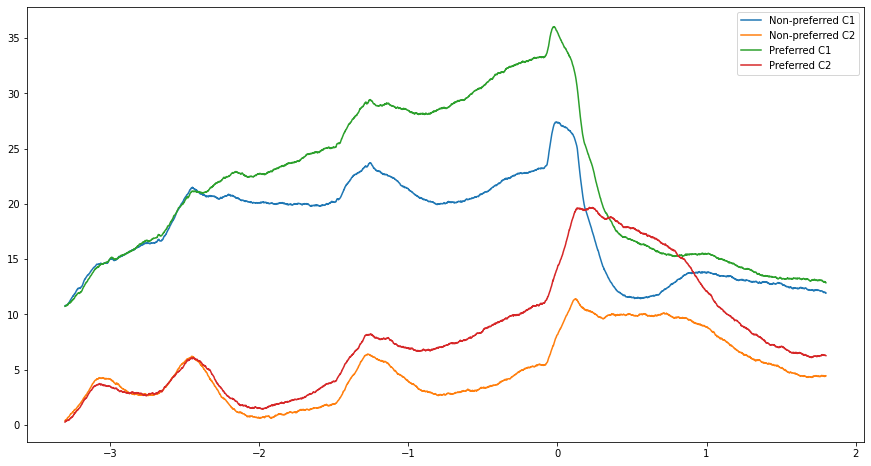

In [ ]:
# computing PC time series
pcNopr = eigenvectors[:, 0:2].T @ chan_avg_Nopr 
# the first two eigenvectors are the ones that we want cause we sorted the columns according to the eigenvalues
pcPref = eigenvectors[:,0:2].T @ chan_avg_Pref

plt.figure(figsize=[15, 8])
plt.plot(t, pcNopr.T, t, pcPref.T)
plt.legend(['Non-preferred C1', 'Non-preferred C2', 
            'Preferred C1', 'Preferred C2'])
plt.show()

# State-space trajectories

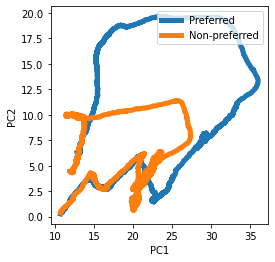

In [ ]:
plt.plot(pcPref[0, :], pcPref[1, :], linewidth=5, label='Preferred')
plt.plot(pcNopr[0, :], pcNopr[1, :], linewidth=5, label='Non-preferred')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect(1/plt.gca().get_data_ratio())
plt.legend()
plt.show()

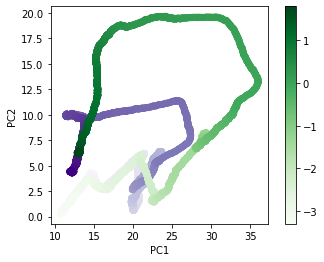

In [ ]:
# Time as hue, to show better the time passing.

plt.scatter(pcNopr[0, :], pcNopr[1, :], cmap='Purples', c=t)
plt.scatter(pcPref[0, :], pcPref[1, :], cmap='Greens', c=t)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.gca().set_aspect(1/plt.gca().get_data_ratio())

plt.show()